In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 集成基本思想：

训练时用多种分类器一起完成同一份任务

![title](./img/1.png)

测试时对待测试样本分别通过不同的分类器，汇总最后的结果

![title](./img/2.png)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

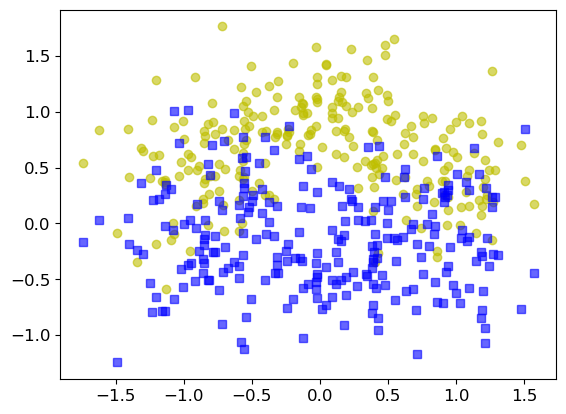

In [3]:
plt.plot(X[:,0][y==0],X[:,1][y==0],'yo',alpha = 0.6)
plt.plot(X[:,0][y==0],X[:,1][y==1],'bs',alpha = 0.6)

### 投票策略：软投票与硬投票
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权平均

#### 硬投票实验

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(estimators =[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='hard')

In [5]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print (clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 软投票实验

In [7]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability = True,random_state=42)

voting_clf = VotingClassifier(estimators =[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='soft')

In [8]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print (clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


软投票：要求必须各个分别器都能得出概率值

### Bagging策略
- 首先对训练数据集进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需得到所有模型结果再进行集成

![title](./img/3.png)

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                  n_estimators = 500,
                  max_samples = 100,
                  bootstrap = True,
                  n_jobs = -1,
                  random_state = 42
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
accuracy_score(y_test,y_pred)

0.904

In [12]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.856

### 决策边界
- 集成与传统方法对比

In [13]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf,X,y,axes=[-1.5,2.5,-1,1.5],alpha=0.5,contour =True):
    x1s=np.linspace(axes[0],axes[1],100)
    x2s=np.linspace(axes[2],axes[3],100)
    x1,x2 = np.meshgrid(x1s,x2s)
    X_new = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,cmap = custom_cmap,alpha=0.3)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1,x2,y_pred,cmap = custom_cmap2,alpha=0.8)
    plt.plot(X[:,0][y==0],X[:,1][y==0],'yo',alpha = 0.6)
    plt.plot(X[:,0][y==0],X[:,1][y==1],'bs',alpha = 0.6)
    plt.axis(axes)
    plt.xlabel('x1')
    plt.xlabel('x2')


Text(0.5, 1.0, 'Decision Tree With Bagging')

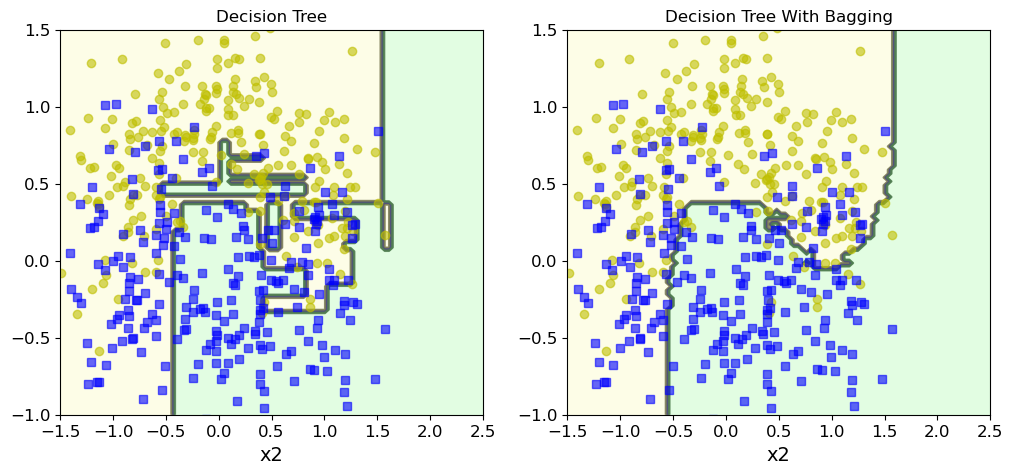

In [14]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plot_decision_boundary(tree_clf,X,y)
plt.title('Decision Tree')
plt.subplot(122)
plot_decision_boundary(bag_clf,X,y)
plt.title('Decision Tree With Bagging')

Colormap颜色：https://blog.csdn.net/zhaogeng111/article/details/78419015

### OOB策略
- Out Of Bag

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                  n_estimators = 500,
                  max_samples = 100,
                  bootstrap = True,
                  n_jobs = -1,
                  random_state = 42,
                  oob_score = True
)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9253333333333333

In [16]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.904

In [17]:
bag_clf.oob_decision_function_

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.01030928, 0.98969072],
       [0.03174603, 0.96825397],
       [0.07672634, 0.92327366],
       [0.39189189, 0.60810811],
       [0.06145251, 0.93854749],
       [0.92689295, 0.07310705],
       [0.88205128, 0.11794872],
       [0.59850374, 0.40149626],
       [0.04896907, 0.95103093],
       [0.7565445 , 0.2434555 ],
       [0.81377551, 0.18622449],
       [0.88528678, 0.11471322],
       [0.07407407, 0.92592593],
       [0.04738155, 0.95261845],
       [0.92051282, 0.07948718],
       [0.69974555, 0.30025445],
       [0.94358974, 0.05641026],
       [0.06100796, 0.93899204],
       [0.224     , 0.776     ],
       [0.9125964 , 0.0874036 ],
       [0.98746867, 0.01253133],
       [0.95967742, 0.04032258],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.03466667, 0.96533333],
       [0.7020202 , 0.2979798 ],
       [0.

### 随机森林

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

特征重要性

In [19]:
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rf_clf.feature_importances_):
    print (name,score)

sepal length (cm) 0.10784163952508344
sepal width (cm) 0.022306999782894302
petal length (cm) 0.4358250845031764
petal width (cm) 0.4340262761888459


Mnist中哪些特征比较重要呢？

In [20]:
from sklearn.datasets import fetch_openml

# 获取 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)


In [25]:
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(mnist['data'],mnist['target'])


RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [26]:
rf_clf.feature_importances_.shape

(784,)

In [27]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis('off')


[Text(1, 0.0, 'Not important'),
 Text(1, 0.009399654111707359, 'Very important')]

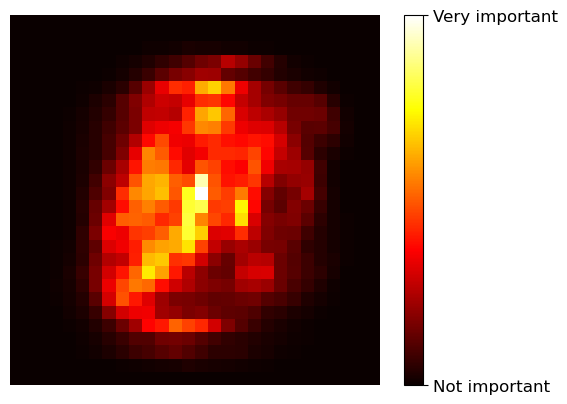

In [28]:
plot_digit(rf_clf.feature_importances_)
char = plt.colorbar(ticks=[rf_clf.feature_importances_.min(),rf_clf.feature_importances_.max()])
char.ax.set_yticklabels(['Not important','Very important'])

### Boosting-提升策略

### AdaBoost
跟上学时的考试一样，这次做错的题，是不是得额外注意，下次的时候就和别错了！

![title](./img/4.png)

以SVM分类器为例来演示AdaBoost的基本策略

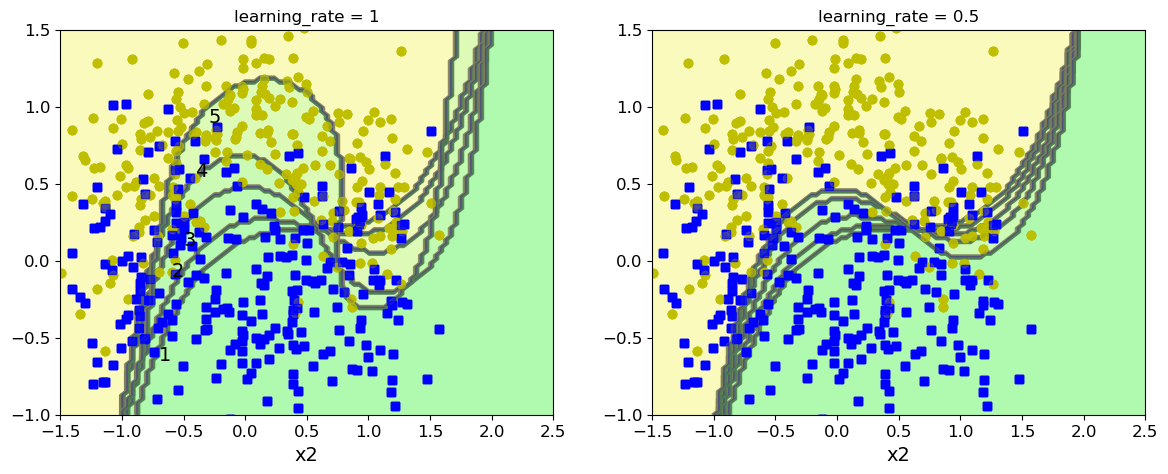

In [29]:
from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(14,5))
for subplot,learning_rate in ((121,1),(122,0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf',C=0.05,random_state=42)
        svm_clf.fit(X_train,y_train,sample_weight = sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1+learning_rate)
        plot_decision_boundary(svm_clf,X,y,alpha=0.2)
        plt.title('learning_rate = {}'.format(learning_rate))
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
plt.show()

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                   n_estimators = 200,
                   learning_rate = 0.5,
                   random_state = 42
)

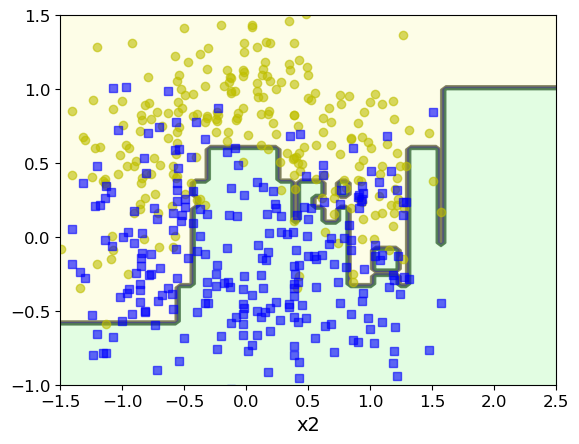

In [31]:
ada_clf.fit(X_train,y_train)
plot_decision_boundary(ada_clf,X,y)

### Gradient Boosting

In [32]:
np.random.seed(42)
X = np.random.rand(100,1)- 0.5
y=3*X**2+0.05*np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

In [34]:
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [35]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [36]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [37]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([[0.64420864, 0.62490592, 0.64444433, 0.54047784, 0.62887269,
        0.65771192, 0.71375099, 0.61394278, 0.59943161, 0.61476843,
        0.68562639, 0.65629384, 0.61336828, 0.66551966, 0.64471016,
        0.68828854, 0.60475363, 0.62347318, 0.62025088, 0.56668054,
        0.6546623 , 0.65290905, 0.64011196, 0.62812693, 0.56908775,
        0.61882402, 0.62272056, 0.59974242, 0.631792  , 0.66005883,
        0.73416558, 0.64858518, 0.65273381, 0.63613399, 0.54391773,
        0.63853059, 0.6428678 , 0.76301839, 0.63023824, 0.65493365,
        0.6381207 , 0.58142238, 0.69699743, 0.67745294, 0.67940788,
        0.59438691, 0.709996  , 0.56976373, 0.66919914, 0.74937907,
        0.59032947, 0.6115414 , 0.64483885, 0.6146825 , 0.56232312,
        0.64328444, 0.5867411 , 0.66353591, 0.59388507, 0.71735301,
        0.60069362, 0.62375321, 0.68053215, 0.57831307, 0.65122928,
        0.70521342, 0.55948212, 0.64908798, 0.65285043, 0.67894743,
        0.57800875, 0.57383346, 0.66595336, 0.65

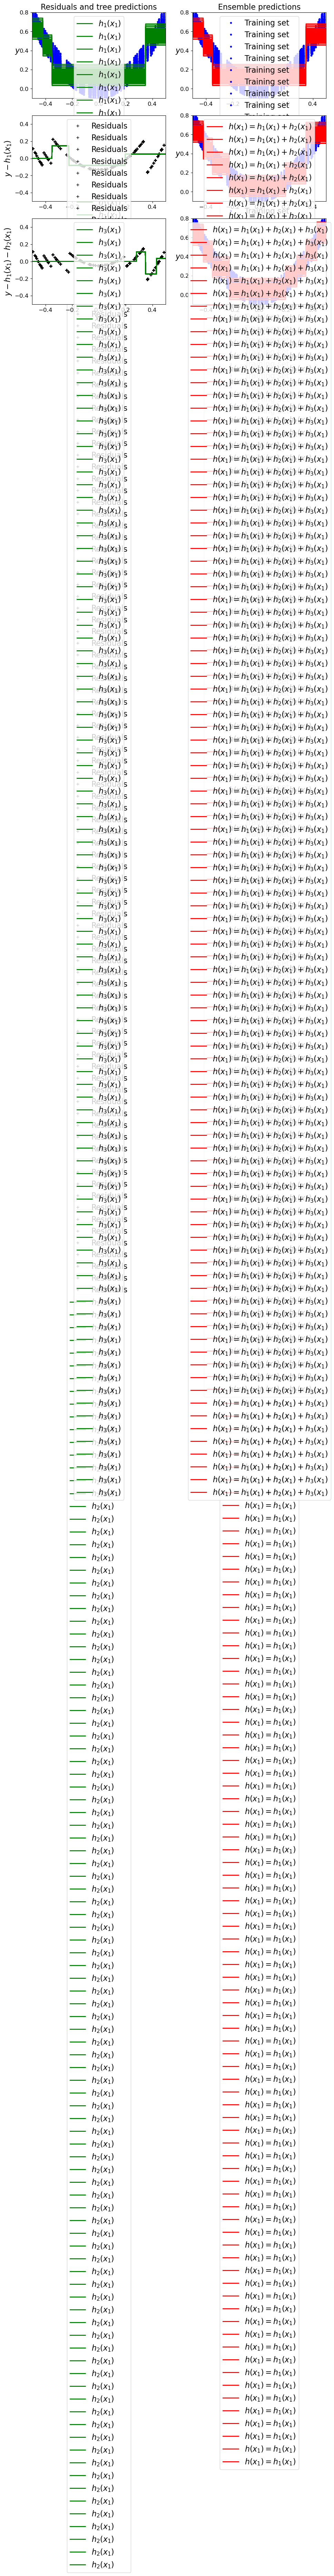

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
X = np.random.rand(100,1)- 0.5
y=3*X**2+0.05*np.random.randn(100)


In [42]:
import pandas as pd
if len(y.shape) == 2 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)
# 处理 Pandas DataFrame
elif isinstance(y, pd.DataFrame):
    y = y.values.ravel()
# 展平但不改变样本数
else:
    y = y.ravel()
y.shape

(100,)

In [43]:
gbrt = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 1.0,
                          random_state = 41
)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=41)

In [44]:
gbrt_slow_1 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 0.1,
                          random_state = 41
)
gbrt_slow_1.fit(X,y.ravel())

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=41)

In [45]:
gbrt_slow_2 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 200,
                          learning_rate = 0.1,
                          random_state = 41
)
gbrt_slow_2.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=41)

Text(0.5, 1.0, 'learning_rate=0.1,n_estimators=3')

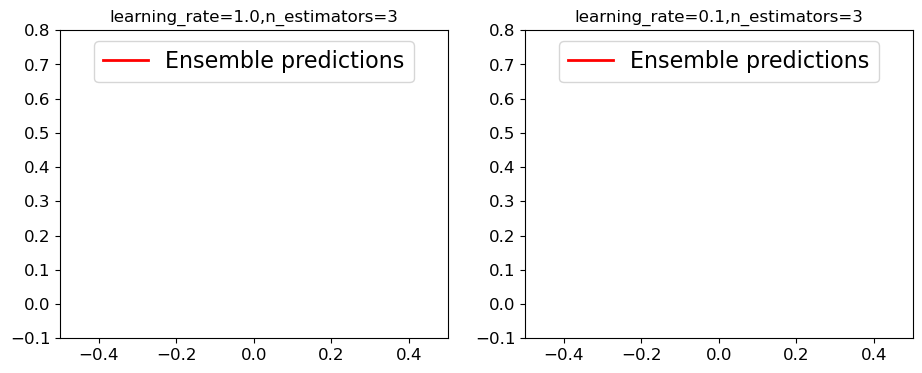

In [46]:
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_predictions([gbrt],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt.learning_rate,gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))


Text(0.5, 1.0, 'learning_rate=0.1,n_estimators=3')

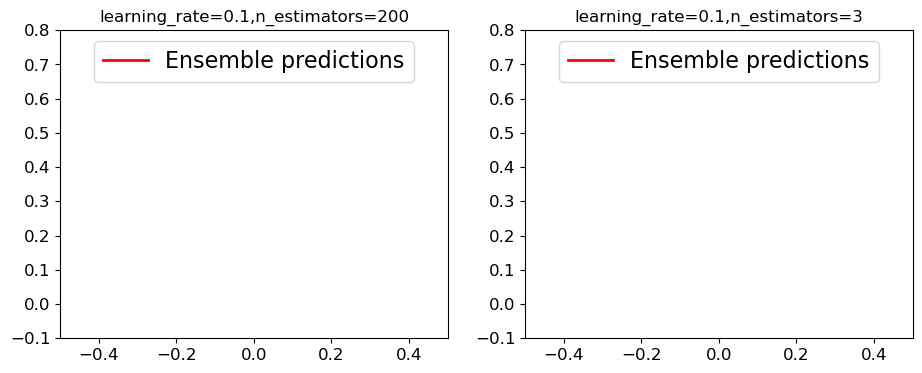

In [47]:
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_predictions([gbrt_slow_2],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_2.learning_rate,gbrt_slow_2.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))


### 提前停止策略

In [48]:
from sklearn.metrics import mean_squared_error
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)
gbrt = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 120,
                          random_state = 42
)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = bst_n_estimators,
                          random_state = 42
)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=1, random_state=42)

In [49]:
min_error = np.min(errors)
min_error

0.0

Text(0.5, 1.0, 'Best Model(1 trees)')

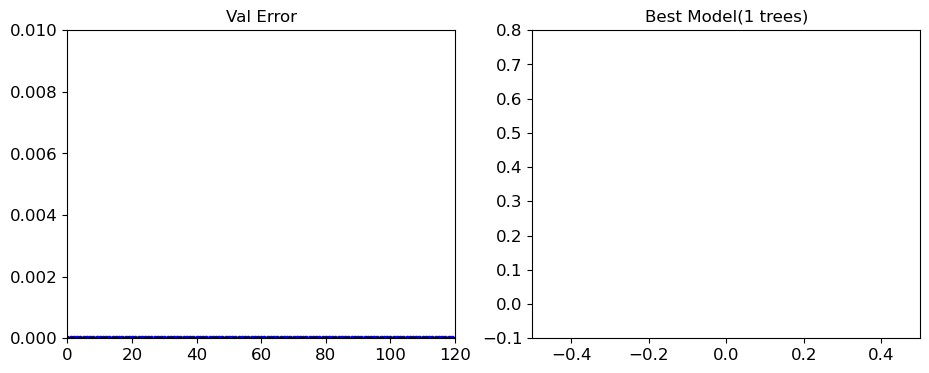

In [50]:
plt.figure(figsize = (11,4))
plt.subplot(121)
plt.plot(errors,'b.-')
plt.plot([bst_n_estimators,bst_n_estimators],[0,min_error],'k--')
plt.plot([0,120],[min_error,min_error],'k--')
plt.axis([0,120,0,0.01])
plt.title('Val Error')

plt.subplot(122)
plot_predictions([gbrt_best],X,y,axes=[-0.5,0.5,-0.1,0.8])
plt.title('Best Model(%d trees)'%bst_n_estimators)


In [53]:
gbrt = GradientBoostingRegressor(max_depth = 2,
                             random_state = 42,
                                 warm_start =True
)
error_going_up = 0
min_val_error = float('inf')

for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up == 5:
            break
        

In [54]:
print (gbrt.n_estimators)

6


### Stacking（堆叠集成）

![title](./img/5.png)

![title](./img/6.png)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

# 获取 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [56]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [57]:
random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

In [60]:
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(random_state=42)
Training the MLPClassifier(random_state=42)


In [61]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [62]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [63]:
rnd_forest_blender.oob_score_

0.9697